In [1]:
import kwant
import numpy as np
import matplotlib.pyplot as plt
import utils, hf
from scipy.optimize import anderson
from tqdm import tqdm

s0 = np.identity(2)
sz = np.diag([1, -1])

norbs=2

graphene = kwant.lattice.general(
    [[1, 0], [1 / 2, np.sqrt(3) / 2]], [[0, 0], [0, 1 / np.sqrt(3)]],
    norbs=norbs
)
a, b = graphene.sublattices

# create bulk system
bulk_graphene = kwant.Builder(kwant.TranslationalSymmetry(*graphene.prim_vecs))
# add sublattice potential
m0 = 0
bulk_graphene[a.shape((lambda pos: True), (0, 0))] = m0 * sz
bulk_graphene[b.shape((lambda pos: True), (0, 0))] = -m0 * sz
# add hoppings between sublattices
bulk_graphene[graphene.neighbors(1)] = s0

# use kwant wraparound to sample bulk k-space
wrapped_syst = kwant.wraparound.wraparound(bulk_graphene)
wrapped_fsyst = kwant.wraparound.wraparound(bulk_graphene).finalized()

In [2]:
def func_onsite(site, U):
    return U * np.ones((2, 2))

def func_hop(site1, site2, V):
    rij = np.linalg.norm(site1.pos - site2.pos)
    return V * np.ones((2, 2))

def calculate_Hint(U, V, Uk, Vk):
    return U * Uk + V * Vk

In [3]:
Us = np.linspace(1e-6, 5, 10)
Vs = np.linspace(1e-6, 5, 10)

In [6]:
dummy_syst, deltas = utils.generate_scf_syst(
    max_neighbor=1, syst=wrapped_syst, lattice=graphene
)

deltas = np.asarray(deltas)
deltas = np.unique(np.stack([*deltas, *-deltas]), axis=(0))


def compute_gap(
    U,
    V,
    H_int,
    max_neighbor=1,
    lattice=graphene,
    filling=2,
    nk=12,
    tol=1e-5,
    norbs=norbs,
    nk_dense=60,
    mixing=0.5,
    order=1,
):
    # Generate coarse-grid k-points
    ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
    # Generate Hamiltonian on a k-point grid
    hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)
    # Generate guess on the same grid
    guess = utils.generate_guess(max_neighbor, norbs, lattice, ks, ks, dummy_syst)
    # Find groundstate Hamiltonian on the same grid
    hk = hf.find_groundstate_ham(
        H_int=H_int,
        nk=nk,
        filling=filling,
        hamiltonians_0=hamiltonians_0,
        tol=tol,
        guess=guess,
        mixing=mixing,
        order=order,
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(hk)
    # Extract coarse-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, 2)
    # Compute coarse-grid gap
    gap1 = utils.calc_gap(vals, E_F)
    # Generate kwant system with k-grid Hamiltonian
    scf_syst = utils.hk2syst(deltas, hk, ks, dk, max_neighbor, norbs, lattice)
    # Generate dense-grid k-points
    ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
    # Compute groundstate Hamiltonian on a dense grid
    scf_ham = utils.syst2hamiltonian(
        kxs=ks_dense, kys=ks_dense, syst=scf_syst, params={}
    )
    # Diagonalize groundstate Hamiltonian
    vals, vecs = np.linalg.eigh(scf_ham)
    # Extract dense-grid Fermi energy
    E_F = utils.get_fermi_energy(vals, 2)

    gap2 = utils.calc_gap(vals, E_F)
    return gap1, gap2


def compute_phase_diagram(Us, Vs, nk, tol, mixing, order):
    ks = np.linspace(0, 2 * np.pi, nk, endpoint=False)

    Uk = utils.potential2hamiltonian(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=1, V=0),
        ks=ks,
    )

    Vk = utils.potential2hamiltonian(
        syst=wrapped_syst,
        lattice=graphene,
        func_onsite=func_onsite,
        func_hop=func_hop,
        params=dict(U=0, V=1),
        ks=ks,
    )
    gap = []
    for U in tqdm(Us):
        gap_U = []
        for V in Vs:
            H_int = calculate_Hint(U, V, Uk, Vk)
            gap_U.append(
                compute_gap(
                    U=U, V=V, H_int=H_int, nk=nk, tol=tol, mixing=mixing, order=order
                )
            )
        gap.append(gap_U)
    return np.asarray(gap, dtype=float)

In [8]:
gap = compute_phase_diagram(Us, Vs, nk=3, tol=1e-10, mixing=0.1, order=3)

100%|██████████| 10/10 [02:05<00:00, 12.58s/it]


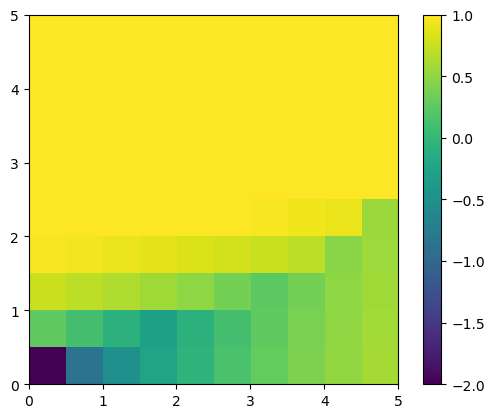

In [13]:
plt.imshow(np.log10(gap[:,:,0]).T, origin='lower', extent=(0, 5, 0, 5), vmin=-2, vmax=1)
plt.colorbar()

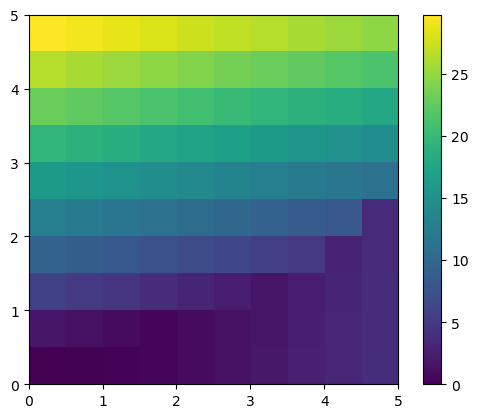

In [14]:
plt.imshow((gap[:,:,0]).T, origin='lower', extent=(0, 5, 0, 5), vmin=0)
plt.colorbar()

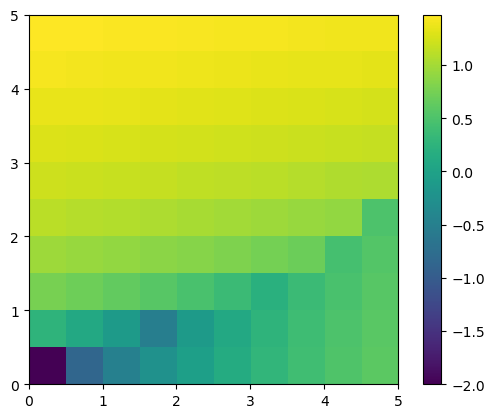

In [15]:
gap = np.asarray(gap, dtype=float)
plt.imshow(np.log10(gap[:,:,1]).T, origin='lower', extent=(0, 5, 0, 5), vmin=-2)
plt.colorbar()

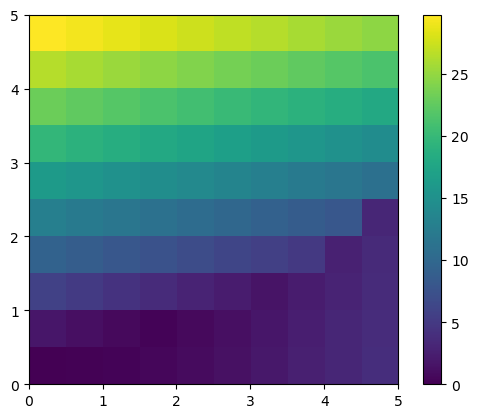

In [16]:
gap = np.asarray(gap, dtype=float)
plt.imshow((gap[:,:,1]).T, origin='lower', extent=(0, 5, 0, 5), vmin=0)
plt.colorbar()

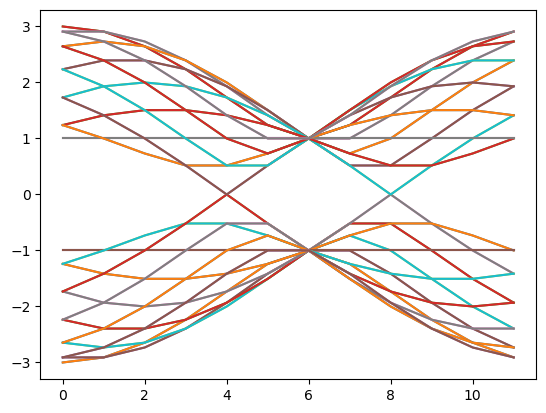

In [12]:
nk=12
ks, dk = np.linspace(0, 2 * np.pi, nk, endpoint=False, retstep=True)
hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)

vals0, vecs0 = np.linalg.eigh(hamiltonians_0)
for i in range(len(vals0[:, 0, 0])):
    for j in range(4):
        plt.plot(vals0[i, :, j])

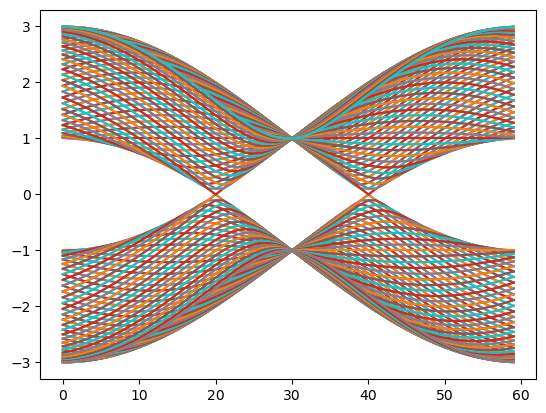

In [21]:
dummy_syst = utils.hk2syst(deltas, hamiltonians_0, ks, dk, max_neighbor=1, norbs=2, lattice=graphene)
# dense grid calculation
nk_dense=60
ks_dense = np.linspace(0, 2 * np.pi, nk_dense, endpoint=False)
dummy_ham = utils.syst2hamiltonian(
    kxs=ks_dense, kys=ks_dense, syst=dummy_syst, params={}
)

vals0, vecs0 = np.linalg.eigh(dummy_ham)
for i in range(len(vals0[:, 0, 0])):
    for j in range(4):
        plt.plot(vals0[i, :, j])

In [16]:
def f(x, a):
    return x + a

In [13]:
anderson(f, 0, options={
        "initial_tr_radius": 1e-3,
        "verbose": 2,
    },)

TypeError: Anderson.__init__() got an unexpected keyword argument 'args'

In [7]:
ks = np.linspace(1, 2 * np.pi, 5, endpoint=False)
guess = utils.generate_guess(
    max_neighbor=1, norbs=2, lattice=graphene, kxs=ks, kys=ks, dummy_syst=dummy_syst
)

In [9]:
_guess = np.stack([guess.real, guess.imag])
_guess.shape

(2, 5, 5, 4, 4)

In [7]:
np.allclose(guess - np.transpose(guess, axes=(0, 1, 3, 2)).conj(), 0)

True

In [11]:
guess[3,2].real

array([[-0.57401604, -0.04869629, -0.42378822, -0.28515123],
       [-0.04869629,  0.93821601,  0.1597249 , -0.38622518],
       [-0.42378822,  0.1597249 ,  0.26506872, -0.44453564],
       [-0.28515123, -0.38622518, -0.44453564,  0.21479535]])

In [6]:
guess[3,2].imag

NameError: name 'guess' is not defined

In [10]:
np.abs(guess[0,0])

array([[0.94243244, 0.62198877, 4.34697286, 2.38297099],
       [0.62198877, 0.15428976, 2.38297099, 0.03505735],
       [4.34697286, 2.38297099, 0.30343558, 0.09211752],
       [2.38297099, 0.03505735, 0.09211752, 0.14885851]])

In [11]:
hamiltonians_0 = utils.syst2hamiltonian(kxs=ks, kys=ks, syst=wrapped_fsyst)

In [12]:
hamiltonians_0[0,0].shape

(4, 4)

In [13]:
hamiltonians_0 + guess

array([[[[ 9.42432436e-01+0.00000000e+00j,
           6.10391571e-01+1.19549831e-01j,
           6.66677666e+00-2.20835887e+00j,
           1.50291553e+00-1.84926895e+00j],
         [ 6.10391571e-01-1.19549831e-01j,
          -1.54289761e-01+0.00000000e+00j,
           2.30970820e+00+5.86343573e-01j,
           2.57358139e+00-8.52494626e-01j],
         [ 6.66677666e+00+2.20835887e+00j,
           2.30970820e+00-5.86343573e-01j,
          -3.03435580e-01+0.00000000e+00j,
           3.31697967e-02-8.59383642e-02j],
         [ 1.50291553e+00+1.84926895e+00j,
           2.57358139e+00+8.52494626e-01j,
           3.31697967e-02+8.59383642e-02j,
           1.48858511e-01+0.00000000e+00j]],

        [[ 9.42432436e-01+0.00000000e+00j,
           6.10391571e-01+1.19549831e-01j,
           5.33306296e+00+7.67257851e-02j,
           1.53896236e+00-9.52240420e-01j],
         [ 6.10391571e-01-1.19549831e-01j,
          -1.54289761e-01+0.00000000e+00j,
           1.51093168e+00+9.96118678e-01j,
    